Канунникова Юлия МОАД 1

In [14]:
import pandas as pd
import re
import string
import pymorphy3
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from IPython.display import display
import time
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirralz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
neg_df = pd.read_csv("negative.csv", sep=";", header=None, usecols=[3, 4], names=["text", "label"], quotechar='"')
pos_df = pd.read_csv("positive.csv", sep=";", header=None, usecols=[3, 4], names=["text", "label"], quotechar='"')
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} колонок")

Размер датасета: 217440 строк, 2 колонок


In [27]:
#Объединяем

df = pd.concat([neg_df, pos_df], ignore_index=True)
def check_and_remove_duplicates(df: pd.DataFrame, remove: bool = False):
    # находим дубликаты
    duplicates = df[df.duplicated(keep=False)]
    
    if duplicates.empty:
        print("В датасете нет повторяющихся строк.")
        return df
    
    # выводим количество и пример дубликатов
    print(f"Найдено {duplicates.shape[0]} повторяющихся строк.")
    # display(duplicates)  # если хочешь посмотреть сами дубликаты
    
    if remove:
        df = df.drop_duplicates(keep="first")  # удаляем дубликаты
        print("Повторяющиеся строки удалены, оставлено одно уникальное значение.")
    
    return df

# сначала удаляем дубликаты по всем столбцам
df = check_and_remove_duplicates(df, remove=True)

# очищаем текст
df["text"] = df["text"].parallel_apply(clean_text)

# после очистки текста снова удаляем дубликаты по колонке 'text'
df = check_and_remove_duplicates(df, remove=True)

# сбрасываем индекс
df = df.reset_index(drop=True)

В датасете нет повторяющихся строк.


Найдено 8843 повторяющихся строк.
Повторяющиеся строки удалены, оставлено одно уникальное значение.


In [28]:
# инициализация лемматизатора и стоп-слов
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words("russian"))

# объединяем данные и перемешиваем
df = pd.concat([neg_df, pos_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# инициализируем pandarallel
pandarallel.initialize(progress_bar=True)

def clean_text(text):
    # удаляем @никнеймы
    text = re.sub(r"@\S+", "", text)

    # удаляем "RT" в начале строки (ретвиты)
    text = re.sub(r"^RT\s+", "", text)

    # удаляем нежелательные символы, кроме скобок и смайликов
    text = re.sub(r"[?/|<>&;:\=%!@#__$1234567890#—ツ►๑۩۞۩•*”˜˜”°`,.]", "", text)

    # разделяем скобки пробелами
    text = re.sub(r"([$begin:math:text$$end:math:text$])", r" \1 ", text)

    words = re.findall(r"\w+|[()]", text)

    # удаляем стоп-слова и лемматизируем
    words = [morph.parse(word)[0].normal_form for word in words if word.lower() not in stop_words]

    return " ".join(words)

# применяем параллельно
df["text"] = df["text"].parallel_apply(clean_text)

# выводим результаты
display(df.head())
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} колонок")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,text,label
0,хороший подруга перестать гулять ради негоа го...,-1
1,полна оценить дружба метить отдовать самый дор...,-1
2,дом градус ( привет вечный простуда,-1
3,многие проблема учёба психологический поэтому ...,1
4,н,-1


Размер датасета: 217440 строк, 2 колонок


In [29]:
#разбиваем на train/test (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
print(f"\nРазмеры выборок: Train — {len(train_df)}, Test — {len(test_df)}")


Размеры выборок: Train — 173952, Test — 43488


In [31]:
# проверяем распределение классов в выборках
train_class_distribution = train_df["label"].value_counts(normalize=True)
test_class_distribution = test_df["label"].value_counts(normalize=True)

print("\nРаспределение классов в тренировочной выборке:")
display(train_class_distribution)

print("\nРаспределение классов в тестовой выборке:")
display(test_class_distribution)


Распределение классов в тренировочной выборке:


label
 1    0.507709
-1    0.492291
Name: proportion, dtype: float64


Распределение классов в тестовой выборке:


label
 1    0.507703
-1    0.492297
Name: proportion, dtype: float64

In [32]:
#уменьшим тренировочную выборку до 6% чтобы сэкономить миллион миллионов лет
train_sample = train_df.sample(frac=0.06, random_state=42)

#подготавливаем данные для doc2vec
train_corpus = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(train_sample["text"])]
test_corpus = [text.split() for text in test_df["text"]]

start_time = time.time()

#обучаем doc2vec
model = Doc2Vec(vector_size=100, window=3, min_count=2, workers=2, epochs=5)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
end_time = time.time()

X_train = [model.infer_vector(doc.words) for doc in train_corpus]
X_test = [model.infer_vector(doc) for doc in test_corpus]

y_train = train_sample["label"].values
y_test = test_df["label"].values

#выводим размер векторов
print(f"\nРазмерность векторов: {len(X_train[0])} значений в каждом")
print(f"\n⏳ Время обучения Doc2Vec: {end_time - start_time:.2f} секунд")


Размерность векторов: 100 значений в каждом

⏳ Время обучения Doc2Vec: 2.09 секунд


In [37]:
from sklearn.metrics import f1_score

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

start_time = time.time()

for name, model in models.items():
    model.fit(X_train, y_train)  # обучение модели
    y_pred = model.predict(X_test)  # предсказания
    f1_class = f1_score(y_test, y_pred, average=None)  # F-score для каждого класса (-1 и 1)
    results[name] = f1_class  # сохраняем результаты по классам

end_time = time.time()

print("\nРезультаты F-score для классификаторов по классам:")
for model_name, f1 in results.items():
    print(f"{model_name}: Класс -1: {f1[0]:.4f}, Класс 1: {f1[1]:.4f}")
    
print(f"\n⏳ Время обучения всех классификаторов: {end_time - start_time:.2f} секунд")


Результаты F-score для классификаторов по классам:
KNN: Класс -1: 0.6850, Класс 1: 0.6961
SVM: Класс -1: 0.6956, Класс 1: 0.7231
Random Forest: Класс -1: 0.7059, Класс 1: 0.7244

⏳ Время обучения всех классификаторов: 36.93 секунд


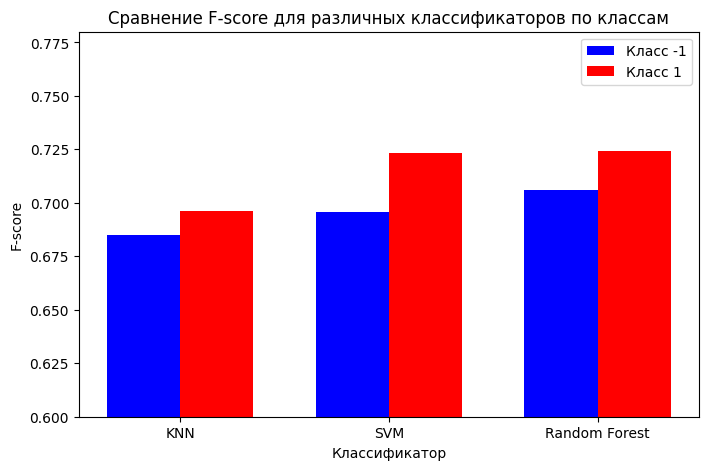

In [39]:
import matplotlib.pyplot as plt

# Готовим данные для графика
class_1_f1 = [f1[1] for f1 in results.values()]  # F1 для класса 1
class_minus_1_f1 = [f1[0] for f1 in results.values()]  # F1 для класса -1

# Создаем график
fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
index = range(len(results))

# Столбцы для класса -1 и класса 1
bar1 = ax.bar(index, class_minus_1_f1, bar_width, label='Класс -1', color='blue')
bar2 = ax.bar([i + bar_width for i in index], class_1_f1, bar_width, label='Класс 1', color='red')

ax.set_xlabel('Классификатор')
ax.set_ylabel('F-score')
ax.set_title('Сравнение F-score для различных классификаторов по классам')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results.keys())
ax.legend()

plt.ylim(0.6, 0.78)  # ограничим ось Y от 0 до 1 для наглядности
plt.show()

In [41]:
from sklearn.model_selection import GridSearchCV

# 1. подбор гиперпараметров для KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 10]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1_weighted', n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 10]}, scoring='f1_weighted')

In [42]:
# 2. подбор гиперпараметров для SVM
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1)
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='f1_weighted')

In [43]:
# 3. подбор гиперпараметров для Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted')

In [44]:
# 4. вывод лучших параметров
print("\nЛучшие параметры для KNN:", knn_grid.best_params_)
print("Лучшие параметры для SVM:", svm_grid.best_params_)
print("Лучшие параметры для Random Forest:", rf_grid.best_params_)


Лучшие параметры для KNN: {'n_neighbors': 10}
Лучшие параметры для SVM: {'C': 1, 'kernel': 'rbf'}
Лучшие параметры для Random Forest: {'max_depth': 20, 'n_estimators': 200}


In [45]:
# 5. пересчёт F-score для лучших моделей
best_knn = knn_grid.best_estimator_
best_svm = svm_grid.best_estimator_
best_rf = rf_grid.best_estimator_

best_knn.fit(X_train, y_train)
best_svm.fit(X_train, y_train)
best_rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [46]:
# 6. F1 для каждого класса (-1 и 1)
knn_best_f1 = f1_score(y_test, best_knn.predict(X_test), average=None)
svm_best_f1 = f1_score(y_test, best_svm.predict(X_test), average=None)
rf_best_f1 = f1_score(y_test, best_rf.predict(X_test), average=None)


In [47]:
# 7. обновляем результаты с F1 для каждого класса
results = {
    "KNN (GridSearch)": knn_best_f1,
    "SVM (GridSearch)": svm_best_f1,
    "Random Forest (GridSearch)": rf_best_f1
}


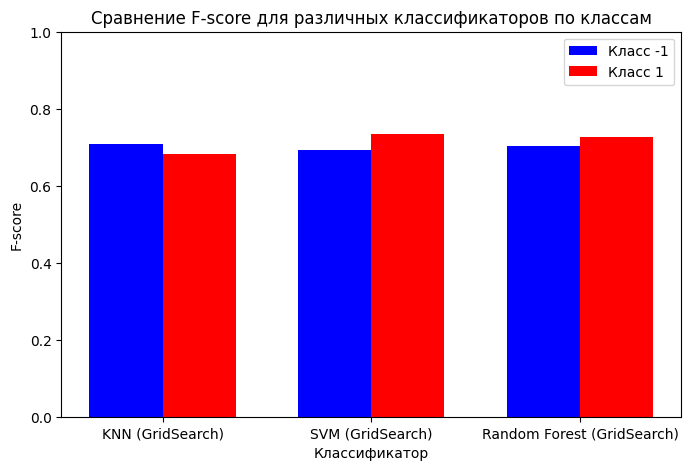


F-score после подбора гиперпараметров:
KNN (GridSearch): Класс -1: 0.7074, Класс 1: 0.6827
SVM (GridSearch): Класс -1: 0.6932, Класс 1: 0.7338
Random Forest (GridSearch): Класс -1: 0.7034, Класс 1: 0.7275


In [48]:
# 8. строим график сравнения F-score для каждого класса
class_1_f1 = [f1[1] for f1 in results.values()]  # F1 для класса 1
class_minus_1_f1 = [f1[0] for f1 in results.values()]  # F1 для класса -1

fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
index = range(len(results))

bar1 = ax.bar(index, class_minus_1_f1, bar_width, label='Класс -1', color='blue')
bar2 = ax.bar([i + bar_width for i in index], class_1_f1, bar_width, label='Класс 1', color='red')

ax.set_xlabel('Классификатор')
ax.set_ylabel('F-score')
ax.set_title('Сравнение F-score для различных классификаторов по классам')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results.keys())
ax.legend()

plt.ylim(0.0, 1.0)  # ограничим ось Y от 0 до 1 для наглядности
plt.show()

# 9. выводим финальные F-score для каждого класса
print("\nF-score после подбора гиперпараметров:")
for model_name, f1 in results.items():
    print(f"{model_name}: Класс -1: {f1[0]:.4f}, Класс 1: {f1[1]:.4f}")

Вывод:

Очистка данных:

В ходе работы с датасетом было принято решение не удалять скобочки, так как они играют важную роль в передаче эмоциональной окраски текста, особенно в таких источниках, как твиты. Скобки часто содержат эмодзи и другие символы, которые могут значительно влиять на восприятие текста, что особенно важно для точной классификации эмоций (положительный или отрицательный класс). Поэтому мы решили сохранить этот элемент в тексте для более точной оценки.

Из полученных результатов видно, что SVM показал наибольшую F1-оценку для класса 1 с результатом 0.7338 и достаточно хорошую оценку для класса -1 — 0.6932. Хотя F1 для класса -1 у SVM не самый высокий, его результат для класса 1 делает его более сбалансированным, чем другие модели. Также, SVM показал наиболее равномерные результаты среди классификаторов, что является важным при работе с данным датасетом.

Заключение:
	Несмотря на то, что Random Forest и KNN показывают неплохие результаты, SVM с оптимальными параметрами (C=1 и kernel=‘rbf’) является наиболее сбалансированным классификатором, с равномерным распределением F1-оценок по классам.
	Решение не удалять скобочки и эмодзи оказалось оправданным, так как они могут значимо влиять на эмоциональный окрас текста.

Таким образом, SVM с оптимизированными гиперпараметрами является лучшим выбором для решения данной задачи классификации твитов.
